# Building a Web Scraping API
## Disney Song Lyrics
In this notebook, I built a web scraper that pulls all lyrics listed within a website of Disney songs. My goal was to:
1. Return specific pieces of information (rather than just downloading a whole page)
2. Iterate over multiple pages/queries
3. Save the data to my computer

Once I gathered the data, I went on to compute some statistical summaries and visualizations that give some new insights into trends within the scraped data. 

## Get List of Links

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import itertools
import re
import numpy as np

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}
main_url = 'https://www.disneyclips.com/lyrics/'
req = Request(url=main_url, headers=headers) 
html_code = urlopen(req).read() 

soup = BeautifulSoup(html_code)

movie_links = []
for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
    movie_links.append(link.get('href'))

regex = re.compile(r'^(?!https)')
movie_links = list(filter(regex.search, movie_links))

movie_links = [main_url + link for link in movie_links]

song_links = []
for movie_link in movie_links:
    res = urlopen(Request(url=movie_link, headers=headers))
    html_code = res.read()
    soup = BeautifulSoup(html_code)
    
    sub_links = []
    for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
        sub_links.append(link.get('href'))
        
    sub_links = list(filter(regex.search, sub_links))
    
    if len(sub_links) == 0:
        song_links.append(movie_link)
    
    else:
        for link in sub_links:
            song_links.append(main_url + link)

len(song_links)

856

## Data Extraction via Scrapy

In [5]:
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd
import logging

import json
class JsonWriterPipeline(object):
    def open_spider(self, spider):
        self.file = open('data/lyricsfinal.jl', 'w')
    def close_spider(self, spider):
        self.file.close()
    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item
    
class LyricSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "lyrics"
    start_urls = song_links
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'data/lyricsfinal.json'                   # Used for pipeline 2
    }
    
    def parse(self, response):
        # Iterate over every element on the page.
        for song in response.xpath('//div[@class="main"]'):
            # Yield a dictionary with the values we want.
            yield {
                'song_name': song.xpath('//div[@class="relativity"]/h1/text()').extract_first(),
                'movie_name': song.xpath('h2[@class="info"]/a/span/text()').extract_first() if song.xpath('h2[@class="info"]/a/span/text()') else song.xpath('h2[@class="info"]/text()').extract()[0].split(' from ')[1] if song.xpath('h2[@class="info"]/text()') else '',
                'writer+performer': song.xpath('p[@class="info"]/text()').extract(),
                'lyrics': ' \n'.join(song.xpath('p/text()').extract()[3:]) if (len(song.xpath('p[@class="info"]/text()').extract())==3) else ' \n'.join(song.xpath('p/text()').extract()[4:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else ' \n'.join(song.xpath('p/text()').extract()[2:])
            }


import sys    
if "twisted.internet.reactor" in sys.modules:
    del sys.modules["twisted.internet.reactor"]
     

process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    'FEED_FORMAT': 'json',
    'FEED_URI': 'data/lyricsfinal.json',
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ajgoldsman',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': True
})  

# Starting the crawler with this spider.
process.crawl(LyricSpider)
process.start()
print('Success!')

2023-01-16 23:26:13 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2023-01-16 23:26:13 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.2.0, Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 21.0.0 (OpenSSL 1.1.1n  15 Mar 2022), cryptography 3.4.8, Platform Windows-10-10.0.22000-SP0
2023-01-16 23:26:13 [scrapy.crawler] INFO: Overridden settings:
{'AUTOTHROTTLE_ENABLED': True,
 'HTTPCACHE_ENABLED': True,
 'LOG_LEVEL': 30,
 'ROBOTSTXT_OBEY': True,
 'USER_AGENT': 'ajgoldsman'}
2023-01-16 23:26:13 [py.warnings] WARNING: C:\Users\ajgol\anaconda3\lib\site-packages\scrapy\extensions\feedexport.py:289: ScrapyDeprecationWarning: The `FEED_URI` and `FEED_FORMAT` settings have been deprecated in favor of the `FEEDS` setting. Please see the `FEEDS` setting docs for more details
  exporter = cls(crawler)



Success!


In [6]:
import pandas as pd

songs = pd.read_json('data/lyricsfinal.json', orient='records')
print(songs.shape)
songs.head()

(856, 4)


,song_name,movie_name,writer+performer,lyrics
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT..."
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...


In [7]:
all_writerperformers = [item for sublist in songs['writer+performer'] for item in sublist]
set([i.split(' by ')[0] for i in all_writerperformers])

{'Arranged and produced',
 'Composed',
 'Lyrics',
 'Lyrics and Music',
 'Lyrics and music',
 'Music',
 'Music and Lyrics',
 'Music and lyrics',
 'Performed',
 'Spanish lyrics',
 'Sung',
 'Words and music',
 'Written',
 'Written and performed',
 'Written and sung'}

In [8]:
# Extract the writer and performer names from the combo key
writer_keys = [
 'Arranged and produced',
 'Composed',
 'Lyrics',
 'Lyrics and Music',
 'Lyrics and music',
 'Music',
 'Music and Lyrics',
 'Music and lyrics',
 'Spanish lyrics',
 'Words and music',
 'Written',
 'Written and performed',
 'Written and sung'
]
performer_keys = [
 'Performed',
 'Sung',
 'Written and performed',
 'Written and sung'
]
writers = [i for i in all_writerperformers if any(i.split(' by ')[0]==k for k in writer_keys)]
performers = [i for i in all_writerperformers if any(i.split(' by ')[0]==k for k in performer_keys)]

songs['writer(s)'] = [[it.lstrip().rstrip().upper() for sub in [i.split(' by ')[-1].replace(', and', ', ').replace(' and ', ', ').replace(' & ', ', ').replace('; ',', ').split(', ') for i in lst if i in writers] for it in sub] for lst in list(songs['writer+performer'])]
songs['performer(s)'] = [[it.split(' as ')[0].lstrip().rstrip().upper() for sub in [i.split(' by ')[-1].replace(', and', ', ').replace(' and ', ', ').replace(' & ', ', ').replace('; ',', ').replace(' with ', ', ').replace(' featuring ', ', ').split(', ') for i in lst if i in performers] for it in sub] for lst in list(songs['writer+performer']) ]

## Dataset Analysis
### Unique Writer Names

In [9]:
unique_writers = list(set([item for sublist in list(songs['writer(s)']) for item in sublist]))
unique_writers[:10]

['FRANK ROGERS',
 'KATE LIGHT',
 'DANNY ELFMAN',
 'ALI DEE THEODORE',
 'PATRICK DOYLE',
 'PHIL COLLINS',
 'DIANE WARREN',
 'TOMMY DANVERS',
 'BRIDGET BENENATE',
 'HARRY GREGSON-WILLIAMS']

### Unique Performer Names

In [10]:
unique_performers = list(set([item for sublist in list(songs['performer(s)']) for item in sublist]))
unique_performers[:10]

['THE MCCLAIN SISTERS',
 "BRENNA D'AMICO",
 'ANTHONY CALLEA',
 'MARNI NIXON',
 'DANNY ELFMAN',
 'BOB NEWHART',
 'PHIL COLLINS',
 'NOËL WELLS',
 'GARRETT CLAYTON',
 'NATHAN LANE']

## Feature Engineering
### Has a Sequel?

In [14]:
movie_list = list(set(songs['movie_name']))
movie_list

['Toy Story 2',
 "Pete's Dragon",
 'The Adventures of Ichabod and Mr. Toad',
 'Sofia the First: The Floating Palace',
 'The Tigger Movie',
 '101 Dalmatians',
 'Meet the Robinsons',
 'Pocahontas II: Journey to a New World',
 'Ralph Breaks the Internet: Wreck-it-Ralph 2',
 'The Hunchback of Notre-Dame',
 'Pocahontas',
 'Aladdin: The Return of Jafar',
 'Planes: Fire and Rescue',
 'Sleeping Beauty',
 'Lady and the Tramp (Live-Action)',
 "Disney's Descendants",
 'The Princess and the Frog',
 'The Lion Guard: Return of the Roar',
 'Sofia the First: Once Upon a Princess',
 'The Many Adventures of Winnie the Pooh',
 'Mulan',
 'Teen Beach 2',
 'Tinker Bell and The Great Fairy Rescue',
 'Atlantis: The Lost Empire',
 'Coco',
 'The Lion King (Live-Action)',
 'Moana',
 "Piglet's Big Movie",
 'Pinocchio',
 'Brother Bear II',
 'Camp Rock 2: The Final Jam',
 'Tangled Before Ever After',
 "A Bug's Life",
 'Cars 3',
 'Raya and the Last Dragon',
 'Finding Dory',
 'High School Musical',
 'Tarzan',
 "Pooh'

In [15]:
sorted_movies = sorted(movie_list, key=len)
sorted_movies

['Coco',
 'Bolt',
 'Cars',
 'Mulan',
 'Moana',
 'Dumbo',
 'Brave',
 'Bambi',
 'Cars 3',
 'Tarzan',
 'Planes',
 'Frozen',
 'WALL-E',
 'Onward',
 'Aladdin',
 'Mulan 2',
 'Tangled',
 'Encanto',
 'Hercules',
 'Frozen 2',
 'Zootopia',
 'Bambi II',
 'Pinocchio',
 'Enchanted',
 'Tarzan II',
 'Camp Rock',
 'Peter Pan',
 'Pocahontas',
 'Cinderella',
 'Robin Hood',
 'Big Hero 6',
 'Toy Story ',
 'Toy Story 2',
 'Toy Story 4',
 'Toy Story 3',
 'Turning Red',
 'Tinker Bell',
 'Melody Time',
 'Teen Beach 2',
 "A Bug's Life",
 'Finding Dory',
 'The Rescuers',
 'Disenchanted',
 'Mary Poppins',
 'Brother Bear',
 'Frozen Fever',
 "Pete's Dragon",
 'Strange World',
 'A Goofy Movie',
 'The Lion King',
 'Incredibles 2',
 '101 Dalmatians',
 'The Aristocats',
 'Monsters, inc.',
 'Wreck-it Ralph',
 'The Lion Guard',
 'Sleeping Beauty',
 'Brother Bear II',
 'Winnie the Pooh',
 'Make Mine Music',
 'The Jungle Book',
 'Lilo and Stitch',
 'Treasure Planet',
 'Elena of Avalor',
 'The Tigger Movie',
 'Teen Beach M

In [16]:
sequel_groups = [[movie_list[i] for i,val in enumerate([sorted_movies[j] in item for item in movie_list]) if val==True] for j in range(len(sorted_movies))]
sequel_groups = [group for group in sequel_groups if len(group)>1]
sequel_groups

[['Cars 3', 'Cars'],
 ['Mulan', 'Mulan 2', 'Mulan (Live-Action)'],
 ['Bambi', 'Bambi II'],
 ['Tarzan', 'Tarzan II'],
 ['Planes: Fire and Rescue', 'Planes'],
 ["Olaf's Frozen Adventure", 'Frozen', 'Frozen 2', 'Frozen Fever'],
 ['Aladdin: The Return of Jafar',
  'Aladdin and the King of Thieves',
  'Aladdin',
  'Aladdin (Live-Action)'],
 ['Tangled Before Ever After', 'Tangled'],
 ['Pinocchio', 'Pinocchio (Live-Action)'],
 ['Enchanted', 'Beauty and the Beast: The Enchanted Christmas'],
 ['Camp Rock 2: The Final Jam', 'Camp Rock'],
 ['Peter Pan', 'Peter Pan II: Return to Neverland'],
 ['Pocahontas II: Journey to a New World', 'Pocahontas'],
 ['Cinderella (2015)',
  'Cinderella',
  'Cinderella III A Twist in Time',
  'Cinderella 2 Dreams Come True'],
 ['Toy Story 2', 'Toy Story 4', 'Toy Story 3', 'Toy Story '],
 ['Tinker Bell and The Great Fairy Rescue',
  'Tinker Bell and the Legend of the NeverBeast',
  'Tinker Bell',
  'Tinker Bell: Secret of the Wings'],
 ['Mary Poppins', 'Mary Poppins 

In [17]:
within_a_series = [title for groups in sequel_groups for title in groups]
within_a_series.remove('Enchanted')   #Was accidentally included because of B&B: Enchanted Christmas
within_a_series = list(np.unique(within_a_series))
within_a_series

['101 Dalmatians',
 "101 Dalmatians 2: Patch's London Adventure",
 'Aladdin',
 'Aladdin (Live-Action)',
 'Aladdin and the King of Thieves',
 'Aladdin: The Return of Jafar',
 'Bambi',
 'Bambi II',
 'Beauty and the Beast',
 'Beauty and the Beast: The Enchanted Christmas',
 'Brother Bear',
 'Brother Bear II',
 'Camp Rock',
 'Camp Rock 2: The Final Jam',
 'Cars',
 'Cars 3',
 'Cinderella',
 'Cinderella (2015)',
 'Cinderella 2 Dreams Come True',
 'Cinderella III A Twist in Time',
 "Disney's Descendants",
 "Disney's Descendants 2",
 "Disney's Descendants 3",
 "Disney's Z-O-M-B-I-E-S",
 "Disney's Z-O-M-B-I-E-S 2",
 "Disney's Z-O-M-B-I-E-S 3",
 'Elena of Avalor',
 'Elena of Avalor: Realm of the Jaquins',
 'Frozen',
 'Frozen 2',
 'Frozen Fever',
 'High School Musical',
 'High School Musical 2',
 'High School Musical 3',
 'High School Musical: The Musical: The Series',
 'Lady and the Tramp',
 'Lady and the Tramp (Live-Action)',
 'Lady and the Tramp (Live-Action) ',
 "Lady and the Tramp 2: Scamp's

In [18]:
#Does the movie have a sequel, or is it a sequel of another movie?
series_bool = [True if movie in within_a_series else False for movie in songs['movie_name']]
songs['sequels'] = series_bool
songs.head(10)

,song_name,movie_name,writer+performer,lyrics,writer(s),performer(s),sequels
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...,[MEL LEVEN],[BILL LEE],True
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...,[MEL LEVEN],[BILL LEE],True
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...,[MEL LEVEN],[LUCILLE BLISS],True
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT...",[RANDY ROGEL],[TIM BENTINCK],True
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...,"[RICHARD GIBBS, BRIAN SMITH, MARTIN LEE FULLER...","[CHARLES DOUG LACY, MICHAEL NOW, JASON FREDERI...",True
5,Try Again,101 Dalmatians 2: Patch's London Adventure,[Music and lyrics by Richard Gibbs and Dean Pi...,To make the winds of fortune blow right \nYou ...,"[RICHARD GIBBS, DEAN PITCHFORD]",[WILL YOUNG],True
6,Friend Like Me,Aladdin,[Music and lyrics by Alan Menken and Howard As...,"But, master, you're in luck 'cause up your sle...","[ALAN MENKEN, HOWARD ASHMAN]",[ROBIN WILLIAMS],True
7,Arabian Nights,Aladdin,[Music and lyrics by Alan Menken and Howard As...,Where it's flat and immense \nAnd the heat is ...,"[ALAN MENKEN, HOWARD ASHMAN]",[BRUCE ADLER],True
8,A Whole New World,Aladdin,"[Music and lyrics by Alan Menken and Tim Rice,...","Tell me, princess, now when did \nYou last let...","[ALAN MENKEN, TIM RICE]","[LEA SALONGA, BRAD KANE]",True
9,A Whole New World (Single),Aladdin,"[Music and lyrics by Alan Menken and Tim Rice,...","Tell me, princess, now when did \nYou last let...","[ALAN MENKEN, TIM RICE]","[PEABO BRYSON, REGINA BELLE]",True


### Lyrics Data

In [19]:
num_verses = [len(lyrics.split(' \n')) for lyrics in songs['lyrics']]
songs['num_verses'] = num_verses

In [20]:
num_words = [len(lyrics.split(' ')) for lyrics in songs['lyrics']]
songs['num_words'] = num_words

In [21]:
songs.head()

,song_name,movie_name,writer+performer,lyrics,writer(s),performer(s),sequels,num_verses,num_words
0,Cruella De Vil,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",If she doesn't scare you \nNo evil thing will ...,[MEL LEVEN],[BILL LEE],True,17,103
1,Dalmatian Plantation,101 Dalmatians,"[Written by Mel Leven, Performed by Bill Lee a...",In this new location \nOur whole aggregation \...,[MEL LEVEN],[BILL LEE],True,6,25
2,Kanine Krunchies,101 Dalmatians,"[Written by Mel Leven, Sung by Lucille Bliss]",Happy dogs are those who eat \nNutritious Kani...,[MEL LEVEN],[LUCILLE BLISS],True,12,62
3,I See Spots,101 Dalmatians 2: Patch's London Adventure,"[Music and lyrics by Randy Rogel, Performed by...","Of those tiny little dots \nYes, it's true \nT...",[RANDY ROGEL],[TIM BENTINCK],True,26,141
4,Thunderbolt Adventure Hour,101 Dalmatians 2: Patch's London Adventure,"[Music by Richard Gibbs, Lyrics by Brian Smith...",Thunderbolt! \nDesperados cringe in fear \nMig...,"[RICHARD GIBBS, BRIAN SMITH, MARTIN LEE FULLER...","[CHARLES DOUG LACY, MICHAEL NOW, JASON FREDERI...",True,9,48


## Visualizations

In [22]:
#popular_artists
df = pd.DataFrame()
df['songs_per_writer'] = [len([songs['writer(s)'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in unique_writers]
df['writer_name'] = unique_writers

df.head()

,songs_per_writer,writer_name
0,1,FRANK ROGERS
1,1,KATE LIGHT
2,12,DANNY ELFMAN
3,2,ALI DEE THEODORE
4,2,PATRICK DOYLE


In [23]:
top_writers = df.sort_values('songs_per_writer', ascending=False)[:15]
top_writers

,songs_per_writer,writer_name
207,99,ALAN MENKEN
146,54,RICHARD M. SHERMAN
112,51,ROBERT B. SHERMAN
304,36,STEPHEN SCHWARTZ
253,34,KRISTEN ANDERSON-LOPEZ
327,34,ROBERT LOPEZ
239,29,TIM RICE
330,28,HOWARD ASHMAN
55,20,RANDY NEWMAN
137,18,LIN-MANUEL MIRANDA


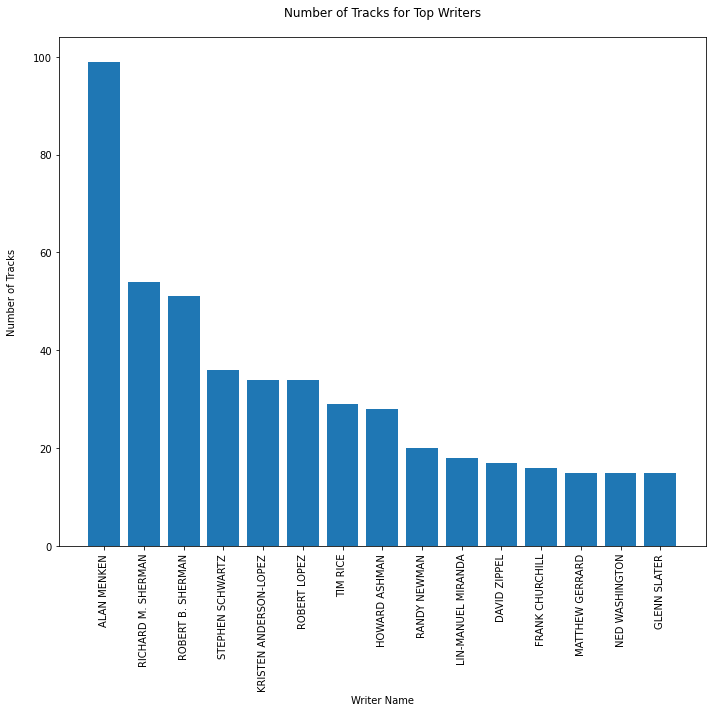

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.bar(top_writers['writer_name'], top_writers['songs_per_writer'])
plt.title("Number of Tracks for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [25]:
#popular_performers
df = pd.DataFrame()
df['songs_per_performer'] = [len([songs['performer(s)'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in unique_performers]
df['performer_name'] = unique_performers

df.head()

,songs_per_performer,performer_name
0,1,THE MCCLAIN SISTERS
1,2,BRENNA D'AMICO
2,1,ANTHONY CALLEA
3,2,MARNI NIXON
4,5,DANNY ELFMAN


In [26]:
top_performers = df.sort_values('songs_per_performer', ascending=False)[:15]
top_performers

,songs_per_performer,performer_name
355,47,CAST
300,46,CHORUS
446,20,DOVE CAMERON
253,16,SOFIA CARSON
71,16,ZAC EFRON
493,15,JIM CUMMINGS
554,14,IDINA MENZEL
123,14,VANESSA HUDGENS
631,12,OLIVIA RODRIGO
646,12,DICK VAN DYKE


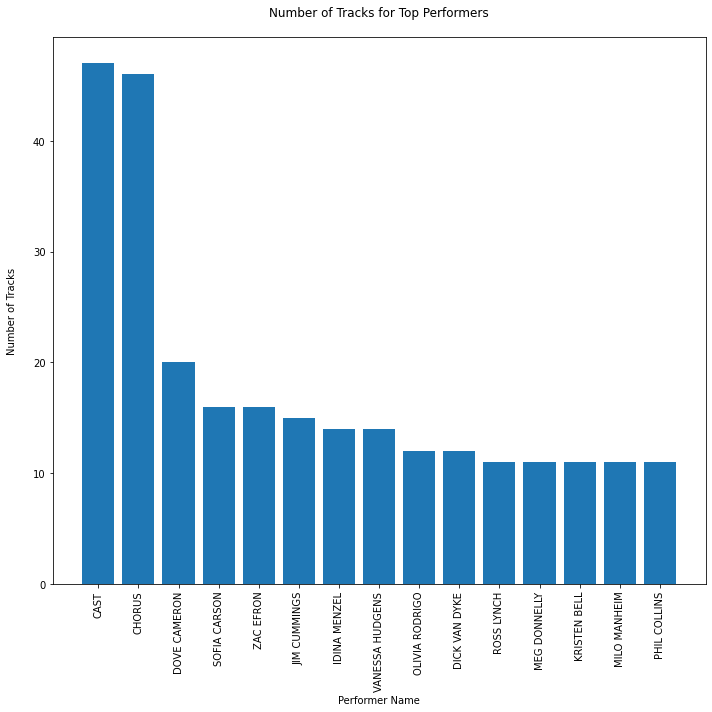

In [27]:
plt.figure(figsize=(10,10))

plt.bar(top_performers['performer_name'], top_performers['songs_per_performer'])
plt.title("Number of Tracks for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [28]:
top_writer_names = list(top_writers['writer_name'])
top_writer_names

['ALAN MENKEN',
 'RICHARD M. SHERMAN',
 'ROBERT B. SHERMAN',
 'STEPHEN SCHWARTZ',
 'KRISTEN ANDERSON-LOPEZ',
 'ROBERT LOPEZ',
 'TIM RICE',
 'HOWARD ASHMAN',
 'RANDY NEWMAN',
 'LIN-MANUEL MIRANDA',
 'DAVID ZIPPEL',
 'FRANK CHURCHILL',
 'MATTHEW GERRARD',
 'NED WASHINGTON',
 'GLENN SLATER']

In [29]:
writer_stats = pd.DataFrame()

writer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['writer_name'] = top_writer_names

writer_stats

,mean_num_verses,mean_num_words,writer_name
0,35.979798,202.909091,ALAN MENKEN
1,27.407407,160.185185,RICHARD M. SHERMAN
2,28.078431,163.156863,ROBERT B. SHERMAN
3,38.305556,219.250000,STEPHEN SCHWARTZ
4,36.058824,230.676471,KRISTEN ANDERSON-LOPEZ
5,36.058824,230.676471,ROBERT LOPEZ
6,33.206897,194.241379,TIM RICE
7,41.607143,237.178571,HOWARD ASHMAN
8,33.950000,192.800000,RANDY NEWMAN
9,56.777778,323.277778,LIN-MANUEL MIRANDA


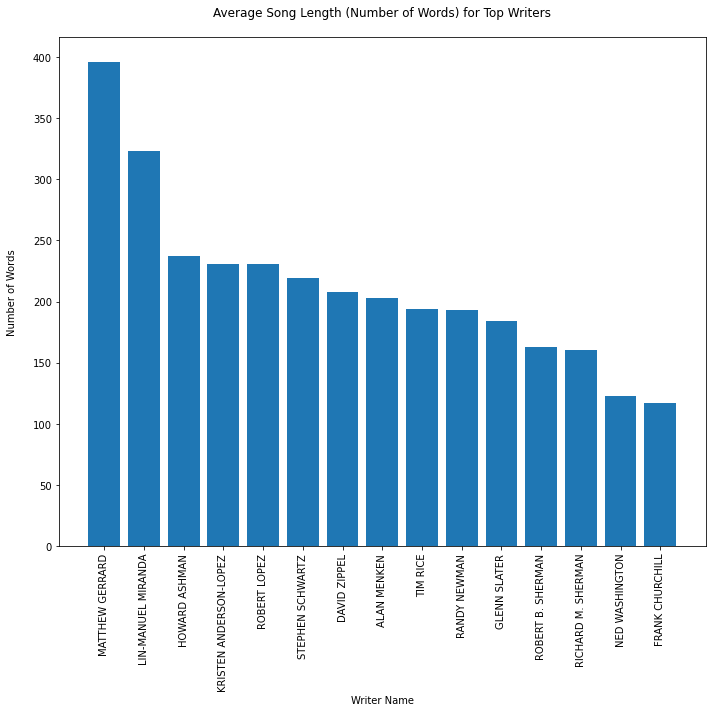

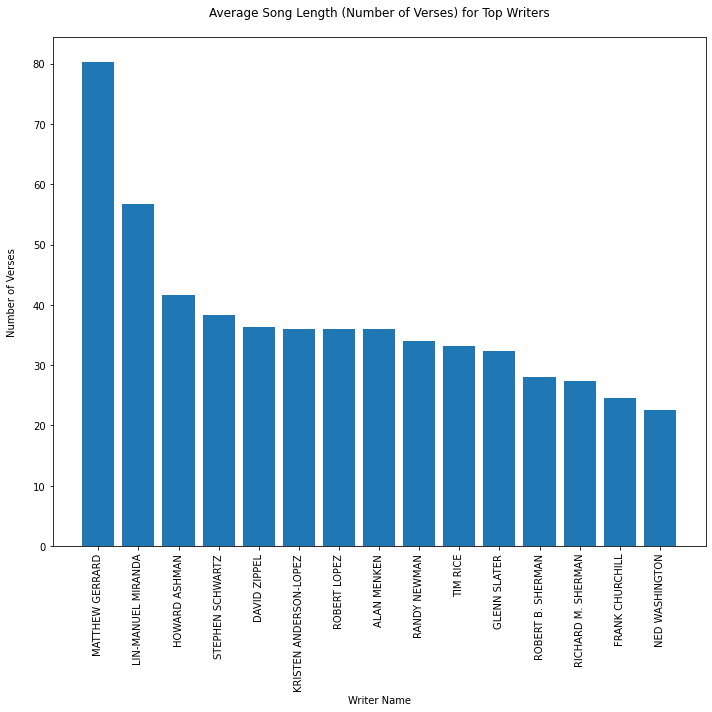

In [30]:
plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()

##############################################

plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()

In [31]:
top_performer_names = list(top_performers['performer_name'])
top_performer_names = top_performer_names[2:]  # drop cast and chorus performer names
top_performer_names

['DOVE CAMERON',
 'SOFIA CARSON',
 'ZAC EFRON',
 'JIM CUMMINGS',
 'IDINA MENZEL',
 'VANESSA HUDGENS',
 'OLIVIA RODRIGO',
 'DICK VAN DYKE',
 'ROSS LYNCH',
 'MEG DONNELLY',
 'KRISTEN BELL',
 'MILO MANHEIM',
 'PHIL COLLINS']

In [32]:
performer_stats = pd.DataFrame()

performer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['performer_name'] = top_performer_names

performer_stats

,mean_num_verses,mean_num_words,performer_name
0,64.300000,379.800000,DOVE CAMERON
1,68.437500,400.750000,SOFIA CARSON
2,53.187500,304.937500,ZAC EFRON
3,29.066667,172.466667,JIM CUMMINGS
4,41.928571,260.214286,IDINA MENZEL
5,48.928571,276.571429,VANESSA HUDGENS
6,40.000000,254.250000,OLIVIA RODRIGO
7,35.166667,204.333333,DICK VAN DYKE
8,47.181818,296.727273,ROSS LYNCH
9,62.818182,343.272727,MEG DONNELLY


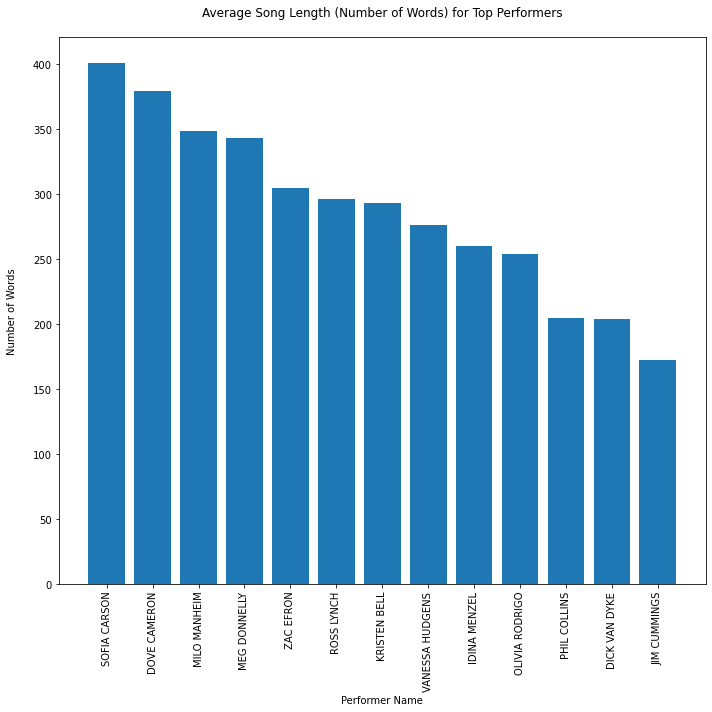

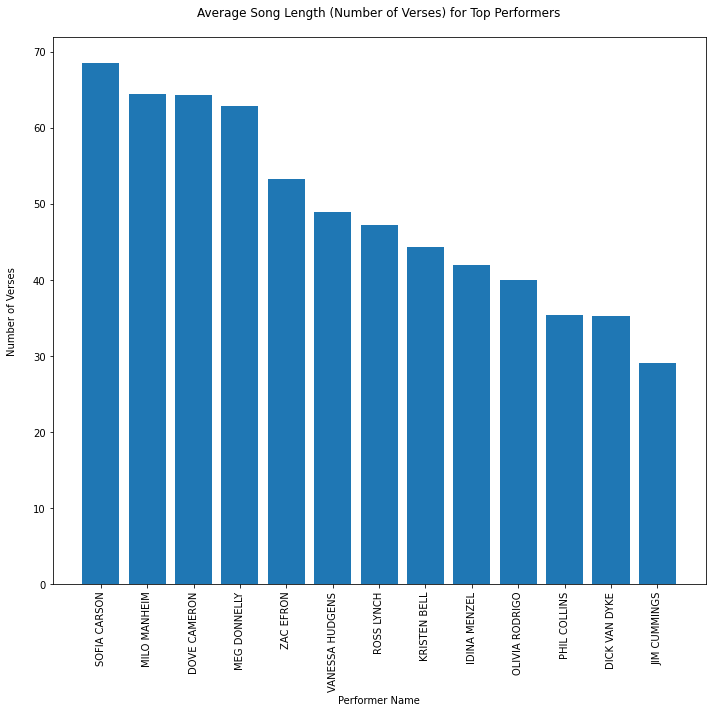

In [33]:
plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()


##############################3

plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()